# The Liberty and Victory Loans Issued to Fund World War I
Team members: Elan Wang, Liam Loughead

In [1]:
import pandas as pd
import numpy as np
import calendar as cal
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
plt.ion()

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import datetime
#%matplotlib ipympl

## Overview
### Questions that will be answered for each bond:
 - What were the features of the bond?
 - Why the bond was issued?
 - How much was authorized and how much was sold?
 - At what price was the bond originally sold and what was the price history on the secondary market?
 - When was the bond redeemed?

In [2]:
Bondh5 = pd.HDFStore("data/BondDF.h5", mode="r")
BondList = Bondh5["BondList"]
BondQuant = Bondh5["BondQuant"]
BondPrice = Bondh5["BondPrice"]
Bondh5.close()
'''
colsfinaldates = [  "Authorizing Act Date",
                    "First Issue Date",
                    "First Redemption Date",
                    "Final Redemption Date",
                    "Redeemable After Date",
                    "Payable Date"
                 ]
BondList = pd.read_csv("data/BondList.csv", index_col=0)
for col in colsfinaldates:
    BondList[col] = pd.to_datetime(BondList[col])

BondQuant = pd.read_csv("data/BondQuant.csv")
BondQuant = BondQuant.set_index(['L1 ID', 'Series'], drop = True)
BondQuant.index = pd.to_datetime(BondQuant.index)

BondPrice = pd.read_csv("data/BondPrice.csv")
BondPrice = BondPrice.set_index(['L1 ID', 'Series'], drop = True)
BondPrice.index = pd.to_datetime(BondPrice.index)
'''

'\ncolsfinaldates = [  "Authorizing Act Date",\n                    "First Issue Date",\n                    "First Redemption Date",\n                    "Final Redemption Date",\n                    "Redeemable After Date",\n                    "Payable Date"\n                 ]\nBondList = pd.read_csv("data/BondList.csv", index_col=0)\nfor col in colsfinaldates:\n    BondList[col] = pd.to_datetime(BondList[col])\n\nBondQuant = pd.read_csv("data/BondQuant.csv")\nBondQuant = BondQuant.set_index([\'L1 ID\', \'Series\'], drop = True)\nBondQuant.index = pd.to_datetime(BondQuant.index)\n\nBondPrice = pd.read_csv("data/BondPrice.csv")\nBondPrice = BondPrice.set_index([\'L1 ID\', \'Series\'], drop = True)\nBondPrice.index = pd.to_datetime(BondPrice.index)\n'

In [3]:
# Helper functions

def get_cf_as_string(row):
    """
    Takes a row from the BondList frame and returns the a string indicating the month which the bond
    is scheduled.
    """
  
    for i in range(1, 13):
        if row[f"CF{str(i).zfill(2)}"] > 0: return cal.month_name[i]
    if row["Ambiguous"] > 0: return "Ambiguous"
    return "N/A"

def is_nan(value):
    """
    Utility to check if a value is nan
    """
    str_value = str(value)
    if str_value == "nan" or str_value == "NaT": return True

## Liberty & Victory Loans

 - [This concise article](https://www.federalreservehistory.org/essays/liberty-bonds#footnote1) gives a summary of the bonds
 - Bonds are conveniently classified under the level three category "Liberty Loan"
 - These bonds were used to fund World War I
 - The below cell isolates and prints information about the liberty loans from the BondList dataframe
 - Note: These are all par bonds, meaning their original price is equal to their face value.

In [4]:
#Change the pandas float format when using the str() function - removes extra 0s and makes
#the output more readable
pd.options.display.float_format = '${:,.0f}'.format

#Define the liberty loans sub-dataframe
BondList.sort_values(by=["First Issue Date"], ascending=True, inplace=True)
liberty_loans = BondList.loc[(BondList['Category L3'] == "Liberty Loan")]
BondList.iloc[:, 0]

#Define a helper function to summarize a bond
def summarize_bond(bond_row):
  noi = bond_row["Treasury's Name Of Issue"] # noi：
  print(f"Bond #{bond_row['Issue L1 ID']}: {noi}{', issued ' + str(bond_row['First Issue Date']) if not is_nan(bond_row['First Issue Date']) else ''}")
  if is_nan(bond_row["Term Of Loan"]):
    print("   No further information")
    return bond_row
  print(f"   Term: {bond_row['Term Of Loan']}, Redeemable: {bond_row['Redeemable After Date']}, Payable: {bond_row['Payable Date']}")
  print(f"   Coupon: {bond_row['Coupon Rate']}, Frequency: {bond_row['Coupons Per Year']}/year, Scheduled Month: {get_cf_as_string(bond_row)}")
  print("---------------------------------------------------")
  return bond_row

#Uncomment to print a summary of all bonds labeled "Liberty Loan"
#liberty_loans.apply(summarize_bond, axis=1)
#print("Done") #Print Done so the cell output does not include the dataframe snippet

In [5]:
#Helper formatting function for large sums of money
def big_numbers_format(x, pos):
    strx = str(x)
    if x >= 1e9:
        return f"{strx[0]}.{strx[1:4]}b"
    if x >= 1e8:
        return f"{strx[:3]}.{strx[3]}m"
    return f"{strx}"

def big_dollars_format(x, pos):
    return f"${big_numbers_format(x, None)}"

#BondQuant_Transposed is months x bond, as opposed to bond x months
BondQuant_Transposed = BondQuant.transpose()
#Do the same for BondPrice
BondPrice_Transposed = BondPrice.transpose()

#define some important dates for context
graph_start_ts = pd.Timestamp("1917-1-1") #Starting the graph from here gives it a nice left margin
join_ts = datetime.datetime.fromisoformat("1917-04-04")
armistice_ts = datetime.datetime.fromisoformat("1918-11-11")
depression_begin_ts = datetime.datetime.fromisoformat("1920-01-01")
depression_end_ts = datetime.datetime.fromisoformat("1921-07-01")

#Helper function to format axes correctly
def format_and_annotate_ax(bond_ids, ax, closest_date):
    #Sets the right limit to the "closest" (to today) date plus 2 months to give it a nice right margin
    ax.set_xlim(left=graph_start_ts, right=closest_date + pd.DateOffset(months=2))

    ax.legend(labels=[BondList.loc[x]["Treasury's Name Of Issue"] for x in bond_ids], bbox_to_anchor=(0.65,-0.2))
    ax.get_legend().set_title("Color, Bond ID")

    war_patch = mpatches.Patch(fc="#ed7784", label='US time in WW1', alpha=0.65)
    ax.axvspan(xmin=join_ts, xmax=armistice_ts, fc="#ed7784", alpha=0.65)
    depression_patch = mpatches.Patch(fc="#ad2df7", label='Depression', alpha=0.65)
    ax.axvspan(xmin=depression_begin_ts, xmax=depression_end_ts, fc="#ad2df7", alpha=0.65)
    twinx = ax.twinx()
    twinx.legend(handles=[war_patch, depression_patch], bbox_to_anchor=(1,-0.2), title="Events")
    twinx.set_axis_off()
    plt.grid(True)

In [6]:
#Taking a list of bond IDs, create a graph of their quantities in the Public Holdings category
#Creates a new figure for each graph
def graph_public_for_bqs(bond_ids, axes=None, title=""):
    plt.figure(num=random.randint(0, 10000))
    current_ax = plt.gca()
    closer_date = graph_start_ts
    for id in bond_ids:
        series = BondQuant_Transposed.loc[(id, 'Public Holdings')]
        series = series[series.notna()]
        ax = series.plot.line(ax=current_ax, title=title,
                              legend=True, sharex=True, sharey=True, xlabel="Time",
                              ylabel="Quantity of Bonds", **{'marker': '.'})
        if current_ax == None: current_ax = ax
        closer_date = series.index[len(series)-1] if series.index[len(series)-1] > closer_date else closer_date
    ax.yaxis.set_major_formatter(big_numbers_format)
    format_and_annotate_ax(bond_ids, ax, closer_date)
    plt.gcf().tight_layout()
    plt.show()
    current_ax = None

In [7]:
#Taking a list of bond IDs, create a graph of their average price on the secondary market.
#Creates a new figure for each graph
def graph_avg_price(bond_ids, axes=None, title=""):
    plt.figure(num=random.randint(0, 10000))
    current_ax = plt.gca()
    closer_date = graph_start_ts
    for id in bond_ids:
        series = BondPrice_Transposed.loc[(id, 'Average')]
        series = series[series.notna()]
        if len(series) < 1:
            noi = liberty_loans.loc[id]["Treasury's Name Of Issue"]
            print(f"Warning: bond {noi} could not be graphed, no prices are recorded")
            continue
        ax = series.plot.line(ax=current_ax, title=title,
                              legend=True, sharex=True, sharey=True, xlabel="Time",
                              ylabel="Price of Bonds", **{'marker': '.'})
        if current_ax == None: current_ax = ax
        closer_date = series.index[len(series)-1] if series.index[len(series)-1] > closer_date else closer_date
    ax.yaxis.set_major_formatter(big_dollars_format)
    format_and_annotate_ax(bond_ids, ax, closer_date)
    plt.gcf().tight_layout()
    plt.show()
    current_ax = None

## 1st Liberty Loan of 1917
This loan was the first bond used to fund World War I. It also featured the option to convert it so that it would have a higher coupon rate. Generally, convertible bonds are normally corporate bonds. However, in this case, when a bond is **convertible**, it is able to be converted into an issue with a higher coupon rate (Kang, 2015). Thus, it was converted to having a coupon rate of 4% once and 4.25% twice in 1918. This loan had 4 million subscribers, and offered 2 billion dollars while 3.035 billion dollars were subscribed, but only 2 billion dollars were accepted (Rockoff, 2012). An average of 759 dollars were subscribed (Kang, 2015). 

Bond #162: 1st Liberty Loan of 1917 (3.5%), issued 1917-06-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 3.5, Frequency: 2.0/year, Scheduled Month: June
---------------------------------------------------
Bond #163: 1st Liberty Loan Converted to 4%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: June
---------------------------------------------------
Bond #164: 1st Liberty Loan Converted to 4.25%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: June
---------------------------------------------------
Bond #165: 1st Liberty Loan Second Converted to 4.25%, issued 1918-10-24 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Sche

AttributeError: 'Legend' object has no attribute 'legendHandles'

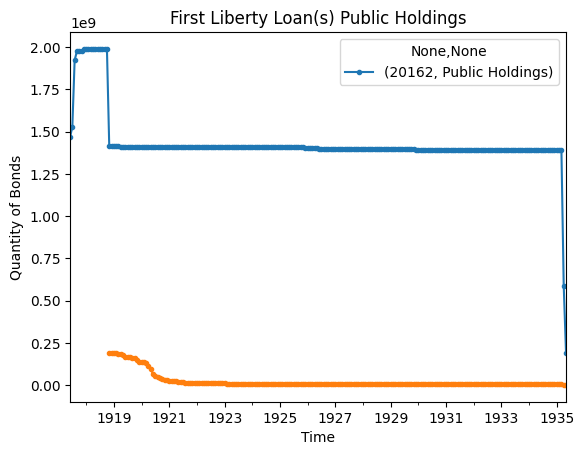

In [8]:
#%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "1st Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="First Liberty Loan(s) Public Holdings")
print("Done")
graph_avg_price(bond_ids, title="First Liberty Loan(s) Secondary Market Price")
print("Done")

Here, it is shown that in 1917, the quantity outstanding was at 1,466,335,094, before increasing to nearly 2,000,000,000 and staying around that price before decreasing to around 1,400,000,000 in 1919, staying at around that amount before suddenly decreasing to around 189,928,800. 
The increase at the beginning can be attributed to many liberty bonds being sold at that time to finance WWI. As this resulted in more citizens and households deciding to own financial assets, the decrease soon after this in late 1919 can be attributed to the increase in discount rates used to curb the increase of bond prices, resulting in depreciation of bond prices. By 1935, most of the debt had already been paid back. 

## 2nd Liberty Loan
This loan was the second bond used to fund World War I. Much like the 1st bond, it had a convertible option; however, unlike the 1st loan, it could only be converted one time, (Kang, 2015). Thus, it was converted to having a coupon rate of 4.25% once in 1918. This loan had 9.4 Million subscribers, and offered 3 billion dollars while 4.618 billion dollars were subscribed, but only 3.809 billion dollars were accepted (Rockoff, 2012). An average of 491 dollars were subscribed (Kang, 2015).

In [ ]:
#%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "2nd Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Second Liberty Loan(s) Public Holdings")
graph_avg_price(bond_ids, title="Second Liberty Loan(s) Secondary Market Price")

## 3rd Liberty Loan
This loan was the third loan used to fund World War I. Unlike the first two loans, it didn't have a convertible option (Kang, 2015). This loan had 18.377 million subscribers, and offered 3 billion dollars while 4.177 billion dollars were subscribed, and all 4.177 billion dollars were accepted (Rockoff, 2012). An average of 227 dollars were subscribed (Kang, 2015). 

In [ ]:
#%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "3rd Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Third Liberty Loan(s) Public Holdings")
graph_avg_price(bond_ids, title="Third Liberty Loan(s) Secondary Market Price")

## 4th Liberty Loan
This loan was the fourth loan used to fund World War I. Like the third loan, it didn't have a convertible option (Kang, 2015). This loan had 22.778 Million subscribers, and offered 6 billion dollars while 6.959 billion dollars were subscribed, and all 6.959 billion dollars were accepted (Rockoff, 2012). An average of 306 dollars were subscribed (Kang, 2015). 

In [ ]:
#%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "4th Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Fourth Liberty Loan(s) Public Holdings")
graph_avg_price(bond_ids, title="Fourth Liberty Loan(s) Secondary Market Price")

## Victory Loans
These were victory loans used after WWI. This differs from the other bonds as they were issued after WWI rather than during it. Like the third and fourth loans, they didn't have convertible options (Kang, 2015). These loans had 11.803 million subscribers, and offered 4.5 billion dollars while 5.25 billion dollars were subscribed, and only 4.5 billion dollars were accepted (Rockoff, 2012). An average of 445 dollars were subscribed (Kang, 2015). 

In [ ]:
#%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "Victory Liberty Loan" in noi or "Vic Lib Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Victory Loan(s) Public Holdings")
graph_avg_price(bond_ids, title="Victory Loan(s) Secondary Market Price")

## Price Drop in 1920-1921
As seen with the Secondary Market Price graphs of the Liberty and Victory Loans, there was a big drop in bond prices from 1920-1921 for all of these loans. This can be attributed to the Depression of 1920-1921. During this period, unemployment rates rose to 12%, and prices saw a 15% rise ("In," 2021). Overall, the economy suffered a large recession. Consequently, the US government lost a significant amount of credibility, meaning higher yields and lower prices for the bonds were demanded. However, the US quickly recovered from this in 1922, meaning the government was able to gain credit back. Thus, yield demand wasn't as high, and prices as a result rose back up again. 

### Events potentially leading to price drop:
Initially, when the US came out of WWI, the economy was expanding largely: unemployment decreased to 1.4% while productivity & inflation both increased ("In," 2021). However, the Federal Reserve, in order to finance military operations, was trying to keep interest rates low (as this would decrease coupon rates), thus "inflation increased unchecked, to the growing consternation of policy advisors" ("In," 2021). Due to reforms initiated to decrease inflation, which included a government spending cut by 75% and an increase of the discount rate, a recession ensued ("In," 2021). 

In [ ]:
#Interactive graph: select a bond by its name, and select the checkboxes to show
#their price and/or quantity history
#Use check marks to show/unshow wartime and 1920-21 depression patches (red and purple respectively)
%matplotlib ipympl

plt.ioff()

war_patch = mpatches.Patch(fc="#ed7784", label='US time in WW1', alpha=0.65)
depression_patch = mpatches.Patch(fc="#ad2df7", label='Depression', alpha=0.65)
possible_colors = ["aqua", "aquamarine", "black", "blue", "brown", "crimson", "darkblue", "darkgreen", "green", "indigo", "maroon", "navy", "orangered", "purple", "teal"]

def bond_name_to_id(name):
    return liberty_loans.loc[liberty_loans["Treasury's Name Of Issue"] == name].index[0]

def id_to_bond_name(id):
    return liberty_loans.loc[id]["Treasury's Name Of Issue"]

fig = plt.figure(num=random.randint(0, 10000))
fig.canvas.header_visible = False
ax = plt.gca()
ax.yaxis.set_major_formatter(big_numbers_format)
ax.set_xlabel("Time")
ax.set_ylabel("Quantity")
twinx = ax.twinx()
twinx.legend(handles=[war_patch, depression_patch], bbox_to_anchor=(1,-0.2), title="Events")
twinx.yaxis.set_major_formatter(big_dollars_format)
twinx.set_ylabel("Price")
plt.grid(True)

initial_options = [id_to_bond_name(x) for x in liberty_loans.index]
name_dropdown = widgets.Dropdown(
    options=initial_options,
    value=initial_options[0],
    description="Name:")
show_quant_checkbox = widgets.Checkbox(value=False, description="Show Quantity")
show_price_checkbox = widgets.Checkbox(value=False, description="Show Price")
show_wartime_checkbox = widgets.Checkbox(value=True, description="Show Wartime")
show_wartime_checkbox.style
show_depression_checkbox = widgets.Checkbox(value=True, description="Show Depression")
legend_textbox = widgets.HTML()

current_depression_polygon = None
current_war_polygon = None

shown_price_names_and_lines = {}
shown_quant_names_and_lines = {}
used_colors = []

using_dropdown_lock = False

#Gets a random color that is not already being used
def _get_available_color():
    available = []
    for color in possible_colors:
        if color not in used_colors: available.append(color)
    color = random.choice(available)
    used_colors.append(color)
    return color

#Plots a series, handles NaN values
def _plot_line(ax, label, series, marker):
    series = series[series.notna()]
    random_color = _get_available_color()
    line2d, = ax.plot(
            [series.index[x].to_pydatetime() for x in range(len(series.index))],
            [series.loc[:][x] for x in range(len(series.index))], label=label, marker=marker, color=random_color)
    return line2d

#The legend is an HTML element with a <table> in it
def _update_legend():
    global legend_textbox
    strs = []
    strs.append("<table><tbody>")
    strs.append("<tr><th>Bond name</th><th>Color</th></tr>")
    lines = list(shown_price_names_and_lines.values()) + list(shown_quant_names_and_lines.values())
    for line2d in lines:
        strs.append(f'<tr style="color: {line2d.get_color()}"><td>{line2d.get_label()}</td><td>{line2d.get_color()}</td></tr>')
    strs.append("</table></tbody>")
    legend_textbox.value = "".join(strs)

#Plot a bond, quantity or price
def add_bond(bond_name, quant):
    global fig, ax, twinx
    bond_id = bond_name_to_id(bond_name)
    if quant:
        series = BondQuant_Transposed.loc[(bond_id, 'Public Holdings')]
    else:
        series = BondPrice_Transposed.loc[(bond_id, 'Average')]
    line2d = _plot_line((ax if quant else twinx), bond_name + (" (Quantity)" if quant else " (Price)"), series, marker="^" if quant else ".")
    (shown_quant_names_and_lines if quant else shown_price_names_and_lines)[bond_name] = line2d
    fig.canvas.draw()
    fig.canvas.flush_events()

#Remove the plot of a bond, quantity or price
def remove_bond(bond_name, quant):
    global fig
    names_and_lines = shown_quant_names_and_lines if quant else shown_price_names_and_lines
    for name, line in names_and_lines.items():
        if line.get_label() == bond_name:
            used_colors.remove(line.get_color())
            line.remove()
            ref2 = names_and_lines.pop(name)
            del ref2
            del line
            break
    fig.canvas.draw()
    fig.canvas.flush_events()

def bond_name_dropdown_handler(unused_arg):
    global using_dropdown_lock
    using_dropdown_lock = True
    name = name_dropdown.value
    show_price_checkbox.value = name in shown_price_names_and_lines
    show_quant_checkbox.value = name in shown_quant_names_and_lines
    using_dropdown_lock = False

def quant_checkbox_handler(unused_arg):
    if using_dropdown_lock: return
    name = name_dropdown.value
    if show_quant_checkbox.value: add_bond(name, True)
    else: remove_bond(name, True)
    _update_legend()

def price_checkbox_handler(unused_arg):
    if using_dropdown_lock: return
    name = name_dropdown.value
    if show_price_checkbox.value: add_bond(name, False)
    else: remove_bond(name, False)
    _update_legend()

def wartime_checkbox_handler(unused_arg):
    global current_war_polygon
    if current_war_polygon == None:
        current_war_polygon = ax.axvspan(xmin=join_ts, xmax=armistice_ts, fc="#ed7784", alpha=0.65)
    else:
        current_war_polygon.remove()
        current_war_polygon = None
    fig.canvas.draw()
    fig.canvas.flush_events()

def depression_checkbox_handler(unused_arg):
    global current_depression_polygon
    if current_depression_polygon == None:
        current_depression_polygon = ax.axvspan(xmin=depression_begin_ts, xmax=depression_end_ts, fc="#ad2df7", alpha=0.65)
    else:
        current_depression_polygon.remove()
        current_depression_polygon = None
    fig.canvas.draw()
    fig.canvas.flush_events()

name_dropdown.observe(bond_name_dropdown_handler)
show_quant_checkbox.observe(quant_checkbox_handler)
show_price_checkbox.observe(price_checkbox_handler)
show_wartime_checkbox.observe(wartime_checkbox_handler)
show_depression_checkbox.observe(depression_checkbox_handler)
wartime_checkbox_handler(None)
depression_checkbox_handler(None)
app = widgets.AppLayout(
    header=widgets.HBox([name_dropdown, show_quant_checkbox, show_price_checkbox]),
    center=widgets.HBox([fig.canvas, legend_textbox]),
    footer=widgets.HBox([show_wartime_checkbox, show_depression_checkbox]),
    merge=True,
    pane_heights=["30px",5,"30px"]
)
app

# Supplementary Materials

### Figures
Each bond has one cell dedicated to it. This cell outputs three items: a worded summary of the features of each bond, a graph of its quantity over time, and a graph of its price on the secondary market over time. Note that many bonds have differing options for interest rates (the convertible bonds), which is why most worded summaries and figures will show different bond entries for the same bond name.

## Dataframe format notes
 - A PDF ReadMe for the dataframe is available on github [here](https://github.com/jepayne/US-Federal-Debt-Public/blob/master/Industrial-Suite/Documentation/ReadMe_Pub_20180910.pdf)
 - The order in which the categories are listed is not necessarily the same; some are switched to make the list read more logically

### BondList
 - Import id is not used
 - Category L* describes the category in level L*
 - Category L* ID is the numeric ID of the above
 - Issue IDs are the numeric ID of a bond within its category
 - L* ID is the bond's ID within level L* (therefore, L1 ID is the unique id for each bond because it is the highest category, so it is the index)
 - Very few of the Authorizing Act Date entries are actually in the raw data, they may need imputing from the Authorizing Act string - for now, if we need an "issuance date" of the security, we use the "First Issue Date" column

### BondQuant and BondPrice
 - By default, the rows are months and the columns are numbers for these dataframes; I find it easier to work with them transposed
 - Always use `series = series[series.notna()]` to filter NaN values reliably

## Works Cited:
  In the Shadow of the Slump: The Depression of 1920-1921. (2021, March 18). Berkley Economic Review. https://econreview.studentorg.berkeley.edu/in-the-shadow-of-the-slump-the-depression-of-1920-1921/
  
  Kang, S. W., & Rockoff, H. (2015). Capitalizing patriotism: the Liberty loans of World War I. Financial History Review, 22(1), 45–78. doi:10.1017/S0968565015000037
  
  Rockoff, Hugh. (2012). Chapter 5 - World War I. *America’s Economic Way of War: War and the US economy from the Spanish-american war to the first Gulf war.* (pp. 99-154). Cambridge University Press. 

